In [1]:
import pandas
import matplotlib
import seaborn
import collections
import igraph
import numpy

%matplotlib inline

matplotlib.rcParams['pdf.fonttype'] = matplotlib.rcParams['ps.fonttype'] = 42
seaborn.set_palette('colorblind')
seaborn.set_style('whitegrid')

In [2]:
import sys
sys.path.append('..')

from helpers import ECOSYSTEMS, DATE_RANGE, load_graph, evolution_regression, evolution_linlog_regressions

In [3]:
FIG_SIZE = (8, 4)

In [4]:
graphs = collections.OrderedDict()

for ecosystem in ECOSYSTEMS:
    print(ecosystem, end=': ')
    graphs[ecosystem] = collections.OrderedDict()
    
    for date in DATE_RANGE: 
        print('.', end='')
        graphs[ecosystem][date] = load_graph(ecosystem, date)
    
    print()

cran: ..................................................................
npm: ..................................................................
rubygems: ..................................................................


## Graph size

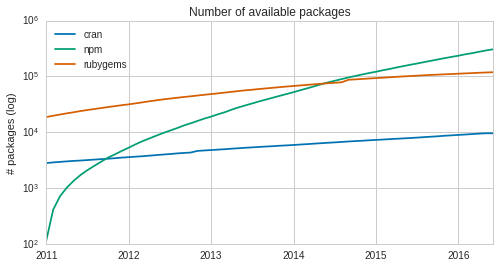

In [28]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        df.loc[date, ecosystem] = graph.vcount()
    
df.plot(ax=ax, logy=True)
    
ax.set(
    xlabel='', 
    ylabel='# packages (log)',
    title='Number of available packages',
)

In [29]:
evolution_linlog_regressions(df.astype(float))

,cran,npm,rubygems
lin-lin,0.989183,0.837272,0.990915
lin-log,0.99524,0.929828,0.977065
log-lin,0.563233,0.353678,0.57258
log-log,0.661795,0.846485,0.720884


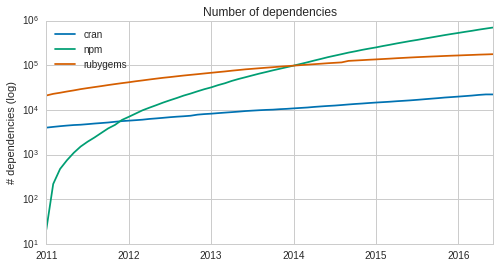

In [30]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        df.loc[date, ecosystem] =  graph.ecount()
    
df.plot(ax=ax, logy=True)
    
ax.set(
    xlabel='', 
    ylabel='# dependencies (log)',
    title='Number of dependencies',
)

In [31]:
evolution_linlog_regressions(df.astype(float))

,cran,npm,rubygems
lin-lin,0.962555,0.8061,0.993422
lin-log,0.997702,0.890951,0.965339
log-lin,0.512463,0.32826,0.57812
log-log,0.660147,0.89409,0.74622


## Graph density

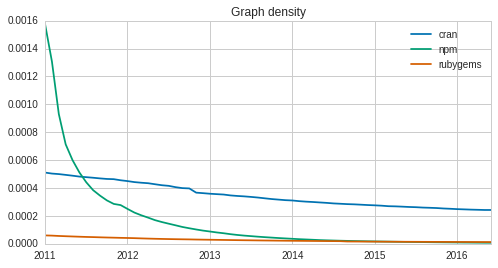

In [32]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        vs = graph.vcount()
        es = graph.ecount()
        df.loc[date, ecosystem] = (es) / (vs * (vs - 1))
    
df.plot(ax=ax)
    
ax.set(
    xlabel='', 
    ylabel='',
    title='Graph density',
)

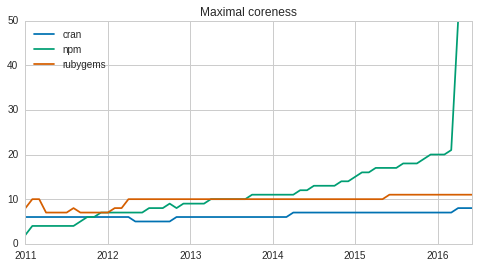

In [33]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        coreness = graph.coreness()
        df.loc[date, ecosystem] = pandas.np.max(coreness)
    
df.plot(ax=ax)

ax.set(
    xlabel='', 
    ylabel='',
    title='Maximal coreness',
)

[None,

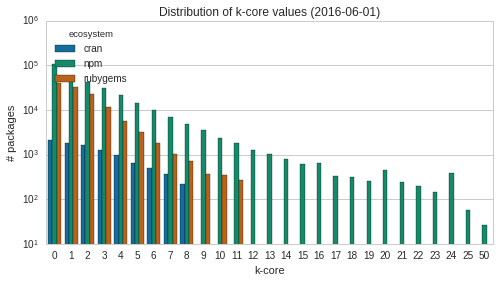

In [34]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

data = []
date = DATE_RANGE[-1]

for ecosystem in ECOSYSTEMS:
    graph = graphs[ecosystem][date]
    
    for value in graph.coreness():
        data.append((ecosystem, value))

data = pandas.DataFrame.from_records(data, columns=['ecosystem', 'k-core'])

seaborn.countplot(
    hue='ecosystem', 
    x='k-core',
    data=data,
    ax=ax
)

ax.set(
    title='Distribution of k-core values ({})'.format(date.strftime('%Y-%m-%d')),
    xlabel='k-core',
    ylabel='# packages',
    yscale='log',
)

[(0, 0.5),

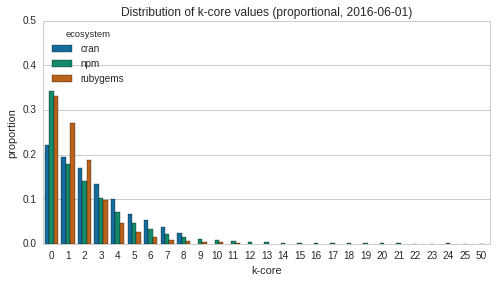

In [35]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

nb_packages = data.groupby('ecosystem').count().rename(columns={'k-core': 'size'})

ndata = (
    data
    .assign(n=1)
    .groupby(['ecosystem', 'k-core'])
    .count()
    .reset_index()
    .merge(nb_packages.reset_index(), how='left', on='ecosystem')
    .assign(p=lambda d: d['n'] / d['size'])
)

seaborn.barplot(
    x='k-core', 
    y='p',
    hue='ecosystem',
    data=ndata,
    ax=ax
)

ax.set(
    title='Distribution of k-core values (proportional, {})'.format(date.strftime('%Y-%m-%d')),
    xlabel='k-core',
    ylabel='proportion',
    ylim=(0, 0.5)
)

## Distribution of dependencies

In [36]:
data = []
date = DATE_RANGE[-1]

for ecosystem in ECOSYSTEMS:
    graph = graphs[ecosystem][date]
    
    for node in graph.vs:
        if node['in'] + node['out'] == 0:
            continue
            
        data.append((
            ecosystem, 
            node['in'],
            node['out'],
            node['tr-in'],
            node['tr-out']
        ))
        
data = (
    pandas.DataFrame.from_records(
        data, 
        columns=['ecosystem', 'in', 'out', 'tr-in', 'tr-out']
    )
    .pipe(
        pandas.melt,
        id_vars='ecosystem', 
        value_vars=['in', 'out', 'tr-in', 'tr-out'], 
        var_name='kind'
    )
)

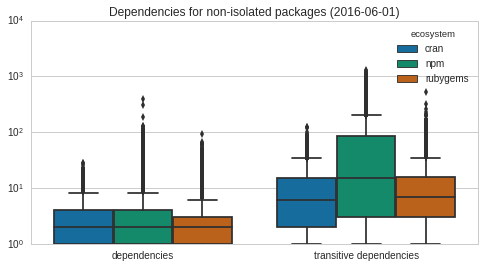

In [37]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

keep_kind = ['out', 'tr-out']

seaborn.boxplot(
    x='kind', 
    y='value', 
    hue='ecosystem',
    data=data[data['kind'].isin(keep_kind)],
    ax=ax,
    hue_order=ECOSYSTEMS,
)

ax.set(
    xlabel='', 
    ylabel='',
    yscale='log',
    title='Dependencies for non-isolated packages ({})'.format(date.strftime('%Y-%m-%d')),
)

ax.set_xticklabels(['dependencies', 'transitive dependencies'])

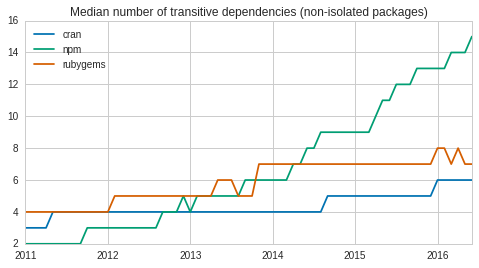

In [38]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        df.loc[date, ecosystem] = numpy.median(
            [v['tr-out'] for v in graph.vs if v['in'] + v['out'] > 0]
        )
    
df.plot(ax=ax)

ax.set(
    xlabel='', 
    ylabel='',
    title='Median number of transitive dependencies (non-isolated packages)',
)

## Isolated packages

[(0, 1),

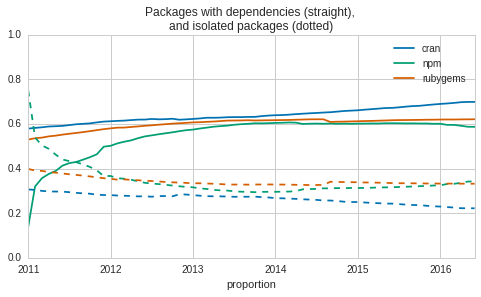

In [39]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)
df2 = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        with_deps = len(list(filter(lambda v: v['out'] > 0, graph.vs)))
        connected = len(list(filter(lambda v: v['in'] + v['out'] > 0, graph.vs)))
        
        df.loc[date, ecosystem] = with_deps / graph.vcount()
        df2.loc[date, ecosystem] = 1 - (connected / graph.vcount())
    
df.plot(ax=ax)
df2.plot(ax=ax, style='--', legend=False, color=seaborn.color_palette())

ax.set(
    xlabel='proportion', 
    ylabel='',
    title='Packages with dependencies (straight), \nand isolated packages (dotted)',
    ylim=(0, 1),
)

[(0, 1),

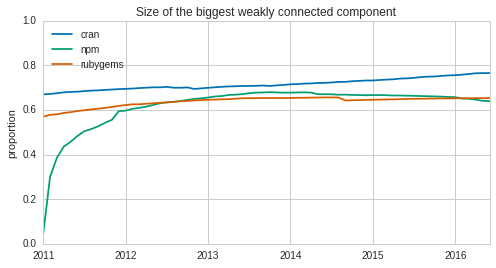

In [40]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        components = graph.components(mode=igraph.WEAK)
        df.loc[date, ecosystem] = components.giant().vcount() / graph.vcount()
    
df.plot(ax=ax)

ax.set(
    xlabel='', 
    ylabel='proportion',
    title='Size of the biggest weakly connected component',
    ylim=(0, 1),
)

[(0, 1),

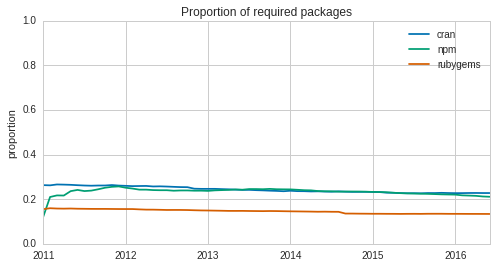

In [5]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        required = len([v for v in graph.vs if v['in'] > 0])
        df.loc[date, ecosystem] = required / graph.vcount()
    
df.plot(ax=ax)

ax.set(
    xlabel='', 
    ylabel='proportion',
    title='Proportion of required packages',
    ylim=(0, 1),
)

## "Hidden" dependencies

In [41]:
# Average depth of dependency chains

# Average maximal depth of dependency chains

# Ratio between direct and transitive dependencies

## Relative impact

[(0, 0.5),

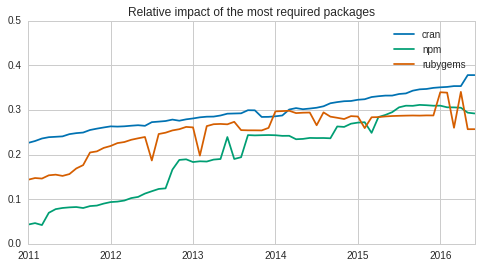

In [42]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        df.loc[date, ecosystem] = max(graph.vs['tr-in']) / graph.vcount()
    
df.plot(ax=ax)

ax.set(
    xlabel='', 
    ylabel='',
    title='Relative impact of the most required packages',
    ylim=(0, 0.5),
)

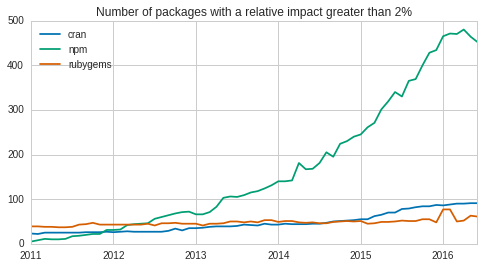

In [43]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

threshold = 2

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        p_threshold = graph.vcount() * threshold / 100
        df.loc[date, ecosystem] = len(list(filter(lambda v: v['tr-in'] >= p_threshold, graph.vs)))
    
df.plot(ax=ax)

ax.set(
    xlabel='', 
    ylabel='',
    title='Number of packages with a relative impact greater than {0}%'.format(threshold),
)

## Reusability metrics

In [44]:
def r_index(values):
    for i, d in enumerate(sorted(values, reverse=True)):
        if (i + 1) >= d:
            return d
    return 0

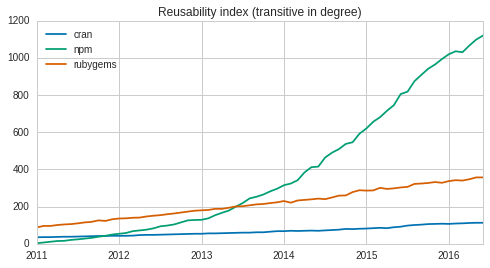

In [45]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        df.loc[date, ecosystem] = r_index(graph.vs['tr-in'])
    
df.plot(ax=ax)

ax.set(
    xlabel='', 
    ylabel='',
    title='Reusability index (transitive in degree)',
)

In [46]:
evolution_linlog_regressions(df.astype(float))

,cran,npm,rubygems
lin-lin,0.959937,0.911217,0.994112
lin-log,0.994949,0.931471,0.982061
log-lin,0.515831,0.42416,0.600684
log-log,0.622331,0.837935,0.71996


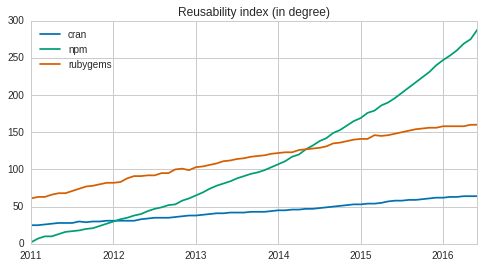

In [47]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        df.loc[date, ecosystem] = r_index(graph.vs['in'])
    
df.plot(ax=ax)

ax.set(
    xlabel='', 
    ylabel='',
    title='Reusability index (in degree)',
)

In [48]:
evolution_linlog_regressions(df.astype(float))

,cran,npm,rubygems
lin-lin,0.992153,0.964321,0.994956
lin-log,0.992489,0.897651,0.966036
log-lin,0.59172,0.511965,0.663741
log-log,0.672675,0.887148,0.741935


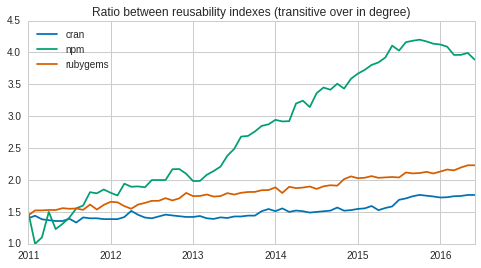

In [49]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        df.loc[date, ecosystem] = r_index(graph.vs['tr-in']) / r_index(graph.vs['in'])
    
df.plot(ax=ax)

ax.set(
    xlabel='', 
    ylabel='',
    title='Ratio between reusability indexes (transitive over in degree)',
)

## Reusability score

[None,

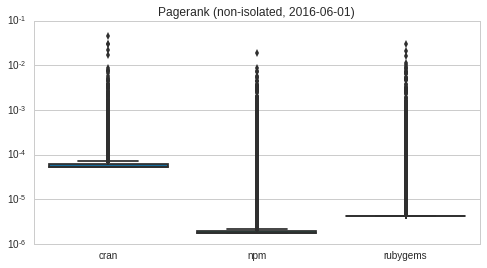

In [50]:
data = []

date = DATE_RANGE[-1]

for ecosystem in ECOSYSTEMS:
    graph = graphs[ecosystem][date]
    pageranks = graph.pagerank()
    
    for v in graph.vs:
        if v['in'] + v['out'] > 0:
            data.append((ecosystem, pageranks[v.index]))


figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame.from_records(data, columns=['ecosystem', 'pagerank'])        
    
seaborn.boxplot(
    x='ecosystem', 
    y='pagerank', 
    data=df, 
    ax=ax
)    

ax.set(
    xlabel='', 
    ylabel='',
    yscale='log',
    title='Pagerank (non-isolated, {})'.format(date.strftime('%Y-%m-%d')),
)

In [51]:
# score = sum(1/d) for all n in "tr in", where d is the distance

# NOT MEMORY EFFICIENT!
# graph = graphs['cran'][DATE_RANGE[-1]]
# paths = graph.shortest_paths(mode=igraph.IN)

graph = graphs['cran'][DATE_RANGE[-1]]

for i, node in enumerate(graph.vs):
    score = sum(1/d for d in graph.shortest_paths(source=node.index, mode=igraph.IN)[0] if d > 0)
    node['r-score'] = score

for node in graph.vs:
    if node['r-score'] > 250:
        print('{}: {}'.format(node['name'], node['r-score']))